# MA6202: Laboratorio de Ciencia de Datos

### **Profesor:** Nicolás Caro

### 12/07/2020 - Tarea 2


### **Integrantes del grupo**: 

# Pregunta 1: Carga y transformacion de datos.

In [1]:
#Estas lineas corren solo en google colab:
import os.path 
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
  if os.path.exists('/content/ChestXRay2017.zip'):
    print("Datos ya descargados")
  else:
    !wget https://data.mendeley.com/datasets/rscbjbr9sj/2/files/f12eaf6d-6023-432f-acc9-80c9d7393433/ChestXRay2017.zip
    !unzip /content/ChestXRay2017.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/PNEUMONIA/person802_bacteria_2708.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person902_bacteria_2827.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person825_bacteria_2736.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1733_bacteria_4566.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person28_bacteria_141.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person494_bacteria_2090.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1088_virus_1800.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person62_bacteria_300.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1328_virus_2295.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1109_bacteria_3050.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person554_bacteria_2320.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person573_bacteria_2369.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1597_bacteria_4192.jpeg  
  inflating: chest_xray/train/P

In [2]:
import torch
import torchvision
from torchvision.datasets.folder import default_loader

In [3]:
# Torchvision transforms compose para carga de datos con transformacion:
root = '/content/chest_xray/train/'

degrees = (-20,20)
transformer = torchvision.transforms.Compose([
    # Escalamiento                                          
    torchvision.transforms.Resize(size = (224,224)),
    # Rotacion con p=0.5
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    # Rotacion entre -20 y 20 grados
    torchvision.transforms.RandomRotation(degrees),
    # Multiplicacion de canales de brillo
    torchvision.transforms.ColorJitter(brightness=[1.2, 1.5]),
    torchvision.transforms.ToTensor(), 
    ])

data_train1 = torchvision.datasets.DatasetFolder(root='/content/chest_xray//train', 
                                                 loader=default_loader, 
                                                 transform=transformer, 
                                                 extensions='jpeg')
data_test1 = torchvision.datasets.DatasetFolder(root='/content/chest_xray//test',
                                                loader=default_loader,
                                                transform=transformer, 
                                                extensions='jpeg')

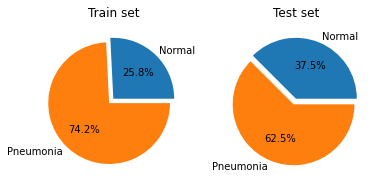

In [4]:
# 2
import matplotlib.pyplot as plt

classes_train1 = data_train1.targets
classes_test1 = data_test1.targets

pneumonia_train=int(sum(classes_train1))
normal_train=len(classes_train1)-pneumonia_train


pneumonia_test=int(sum(classes_test1))
normal_test=len(classes_test1)-pneumonia_test

labels = 'Normal', 'Pneumonia'
sizes_train = [normal_train, pneumonia_train]

sizes_test = [normal_test, pneumonia_test]

fig, axs = plt.subplots(1,2)
axs[0].pie(sizes_train,labels=labels,explode=(0,0.1),autopct='%1.1f%%')
axs[1].pie(sizes_test,labels=labels,explode =(0,0.1),autopct='%1.1f%%')

axs[0].set_title('Train set')
axs[1].set_title('Test set')

plt.show()

In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# split
train_idx, val_idx = train_test_split(list(range(len(data_train1))),test_size=0.2)
#data_train = Subset(data_train1, train_idx)
#data_val   = Subset(data_train1,val_idx)

class ReplicarMuestreoDePrueba(torch.utils.data.Sampler):
    
    def __init__(self,etiquetas_prueba, indices_val, etiquetas_val):
        self.indices_val      = indices_val
        #self.etiquetas_val    = etiquetas_val
        self.prob_pneumonia   = sum(etiquetas_prueba)/len(etiquetas_prueba)
        self.prob_normal      = 1-self.prob_pneumonia
        self.prob_vector      = [ int((etiquetas_val[i]==1 )*self.prob_pneumonia+
                                 (etiquetas_val[i]==0)*self.prob_normal)
                                for i in range(len(etiquetas_prueba))
                                ]
    def __iter__(self):
        return iter(np.random.choice(self.indices_val,p=self.prob_vector))
    
etiquetas_prueba = data_test1.targets
# indices_val = val_idx
etiquetas_val = [data_train1.targets[i] for i in val_idx ] 

a=ReplicarMuestreoDePrueba(etiquetas_prueba,val_idx, etiquetas_val)

In [6]:
from torch.utils.data.sampler import RandomSampler, SubsetRandomSampler
from torch.utils.data import DataLoader

bs = 4

data_train = DataLoader(data_train1, batch_size=bs, sampler=SubsetRandomSampler(train_idx))
data_val   = DataLoader(data_train1, batch_size=bs, sampler=ReplicarMuestreoDePrueba(etiquetas_prueba,val_idx, etiquetas_val))
data_test  = DataLoader(data_test1, batch_size=bs, sampler=RandomSampler(data_test1))

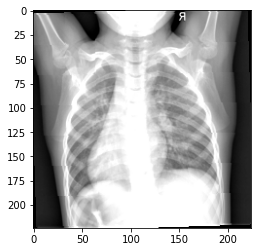

In [7]:
tensor_image = data_train1[0][0].permute(1, 2, 0)
import matplotlib.pyplot as plt
plt.imshow(tensor_image)

# 2 Redes convolucionales profundas

In [8]:
#1 
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(2020)


class DWSepConv2d(nn.Module):
    
    def __init__(self,in_channels, out_channels, kernel_size,padding,bias=True):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels,kernel_size,padding=padding,bias=bias)
        self.conv2 = nn.Conv2d(out_channels, out_channels,kernel_size=1,padding=padding,bias=bias)
    def forward(self,xb):
        xb = F.relu(self.conv1(xb.float()))
        xb = F.relu(self.conv2(xb)) 
        return xb

In [9]:
#2
import torch.nn.functional as F
from torch import nn
class VGG16DWSep(nn.Module):
    
    def __init__(self,in_channels):
        super().__init__()
        # bloque 1
        self.conv1 = nn.Conv2d(in_channels,64,kernel_size=3,padding=1,stride=1)
        self.conv2 = nn.Conv2d(64,64,kernel_size=3, padding=1, stride=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2,stride=2) 
        # bloque 2
        self.dwconv3 = DWSepConv2d(64,128,kernel_size=3,padding=1)
        self.dwconv4 = DWSepConv2d(128,128,kernel_size=3,padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        # bloque 3        
        self.dwconv5 = DWSepConv2d(128,256,kernel_size=3,padding=1)
        self.batchnorm1 = nn.BatchNorm2d(256)
        # bloque 4
        self.dwconv6 = DWSepConv2d(256,256,kernel_size=3,padding=1)
        self.batchnorm2 = nn.BatchNorm2d(256)
        # bloque 5
        self.dwconv7 = DWSepConv2d(256,256,kernel_size=3,padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2,stride=2)
        # bloque 6
        self.dwconv8 = DWSepConv2d(256,512,kernel_size=3,padding=1)
        self.batchnorm3 = nn.BatchNorm2d(512)
        # bloque 7
        self.dwconv9 = DWSepConv2d(512,512,kernel_size=3,padding=1)
        self.batchnorm4 = nn.BatchNorm2d(512)
        # bloque 8
        self.dwconv10 = DWSepConv2d(512,512,kernel_size=3,padding=1)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2,stride=2)
        # bloque o1
        self.flatten1 = nn.Flatten()
        self.lin1 = nn.Linear(739328,1024)
        self.drop1 = nn.Dropout(.7)
        # bloque o2
        self.lin2 = nn.Linear(1024,512)
        self.drop2 = nn.Dropout(.5)
        self.lin3 = nn.Linear(512,2)
    
    def forward(self,xb):
      # bloque 1
      xb = xb.view(-1, 3, 224, 224)
      xb = F.relu(self.conv1(xb))
      xb = F.relu(self.conv2(xb))
      xb = self.maxpool1(xb)
      # bloque 2
      xb = F.relu(self.dwconv3(xb))
      xb = F.relu(self.dwconv4(xb))
      xb = self.maxpool2(xb)
      # bloque 3
      xb = F.relu(self.dwconv5(xb))
      xb = F.relu(self.batchnorm1(xb))
      # bloque 4
      xb = F.relu(self.dwconv6(xb))
      xb = F.relu(self.batchnorm2(xb))
      # bloque 5
      xb = F.relu(self.dwconv7(xb))
      xb = self.maxpool3(xb)
      # bloque 6
      xb = F.relu(self.dwconv8(xb))
      xb = F.relu(self.batchnorm3(xb))
      # bloque 7
      xb = F.relu(self.dwconv9(xb))
      xb = F.relu(self.batchnorm4(xb))
      # bloque 8
      xb = F.relu(self.dwconv10(xb))
      # bloque o1
      xb = self.flatten1(xb)
      xb = F.relu(self.lin1(xb))
      xb = self.drop1(xb)
      # bloque o2
      xb = F.relu(self.lin2(xb))
      xb = self.drop2(xb)
      xb = F.relu(self.lin3(xb))
      return xb.view(-1, xb.size(1))

In [10]:
# Descargamos la red vgg16
vgg16 = torchvision.models.vgg16(pretrained=True, progress=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [11]:
#from torchsummary import summary
#summary(vgg16.cuda(),(3,224,244))

In [12]:
# Se deben obtener las dos primeras capas de convolucion de la red VGG16
for i in range(3):
  print(vgg16.features[i])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [13]:
vgg16.state_dict

<bound method Module.state_dict of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size

In [14]:
# Se quiere la capa 0 y la 2, que son las dos primeras convolucionales:
pesos_dict = {
    'conv1' : vgg16.features[0],
    'conv2' : vgg16.features[2]
}

In [15]:
net = VGG16DWSep(in_channels = 3)

In [16]:
#intento de traspaso de pesos:
net.conv1.weight = pesos_dict['conv1'].weight
net.conv2.weight = pesos_dict['conv2'].weight

In [17]:
# Congelamos los pesos de la red vgg16
for param in vgg16.parameters():
  param.requires_grad = False

In [18]:
# Congelamos los pesos de las dos primeras capas convoluvionales de la red 
# (capas que se transfirieron):
net.conv1.requires_grad_ = False
net.conv2.requires_grad_ = False

In [19]:
# Se elimina la red VGG16 para liberar espacio en colab 
del vgg16
torch.cuda.empty_cache()

In [20]:
# Clase EarlyStopping
# Se requiere la libreria numpy!!
import numpy  as np
class EarlyStopping():
  '''
  Regularization heuristic:

  '''
  def __init__(self, modo='min', paciencia=5, porcentaje:bool = False, tol=0):
    '''
    Arguments:
    ---------
    modo: 'min' o 'max'. Si se debe minimizar o maximizar la metrica objetivo
    paciancia: Cantidad de epocas en la que la metrica puede empeorar
    porcentaje: si la diferencia es relativa (true) o absoluta
    tol: diferencia minima que debe existir con respecto la mejor metrica ya
        observada  para considerar si existe un empeoramiento del desempeno
    '''
    self.modo = modo
    self.paciencia  = paciencia
    self.porcentaje = porcentaje
    self.best = np.Inf if self.modo == 'min' else -np.Inf
    self.contador = 0
    self.tol = tol

  
  def __compareMin(self, metrica_validacion):
    if self.porcentaje:      
      # Si la dif relativa es mayor a la tolerada: actualizar contador:
      if metrica_validacion < (1-self.tol)*self.best:
        self.contador = 0
        self.best = metrica_validacion
        return True
      else:
        self.contador +=1
        return False
    else:
      if metrica_validacion < self.best - self.tol:
        self.best = metrica_validacion
        self.contador = 0
        return True
      else:
        self.contador += 1
        return False
    
    def __comareMax(self, metrica_validacion):
      if self.porcentaje:
         # Si la dif relativa es mayor a la tolerada: actualizar contador:
        if metrica_validacion > (1+self.tol)*self.best:
          self.contador = 0
          self.best = metrica_validacion
          return True
        else:
          self.contador +=1
          return False
      else:
        if metrica_validacion > self.best + self.tol:
          self.best = metrica_validacion
          self.contador = 0
          return True
        else:
          self.contador += 1
          return False        

  # Es necesaria la anotacion??
  #@classmethod
  def __mejor(self, metrica_validacion):
    '''
    Compara @metrica_validacion con la mejor ya observada segun las 
    especificaciones de porcentaje y modo. 
    '''
    if self.modo == 'min':
      # Comparar segun el modo y porcentaje:
      if self.__compareMin(metrica_validacion):
        return True
      else:
        return False
    else:
      # Comparar segun el modo y porcentaje:
      if self.__compareMax(metrica_validacion):
        return True
      else:
        return False

  #@classmethod
  def deberia_parar(self, metrica_validacion):
    if not self.__mejor(metrica_validacion) and self.contador >= self.paciencia:
      return True
    else:
      return False


In [21]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [22]:
import numpy as np 

def register(res_list):
    '''Obtiene la perdida promedio y su desviacion estandar en batches.'''
    
    losses, nums = zip(*res_list)
    
    N = np.sum(nums)
    loss_mean = np.sum(np.multiply(losses, nums))/N
    loss_std = np.sqrt(np.sum(np.multiply((losses-loss_mean)**2, nums))/(N-1))
    
    return loss_mean, loss_std

In [23]:
import pandas as pd
from torch.autograd import Variable
def fit(epochs,
        model,
        loss_func,
        opt,
        train_dl,
        valid_dl,
        metric=None,
        only_print=True,
        print_leap = 1):
    
    '''Fit - Entrena una red neuronal.
    
    Entrena una red neronal dada por model, para esto recibe como argumento
    una funcion de perdida, un optimizador, DataLoaders para entrenamiento 
    y validacion. Muestra en pantalla los errores de validacion y entrega
    como resultado una lista con los resultados del entrenamiento.

    Parameters
    ----------
    epochs: int
        Numero de epocas a entrenar.
            
    model: Mnist_CNN
        Red convolucional tipo Mnist_CNN a entrenar.
           
    loss_func: function
        Funcion de perdida como criterio de la red.
        
    opt: torch.optim Object
        Opimizador de la red.
        
    train_dl: torch.utils.data.dataloader.DataLoader
        DataLoader del conjunto de entrenamiento.
        
    valid_dl:torch.utils.data.dataloader.DataLoader
        DataLoader del conjunto de validacion.
    
    metric: function
        Metrica de rendimiento propia. El modelo se entrena con la funcion de 
        perdida pero se pueden almacenar resultados de prediccion utilizando
        esta metrica.
    
    only_print: bool 
        Indica si se quiere retornar un registro del proceso o solo imprimir 
        en pantalla.
        
    print_leap: int
        Cada cuanntas epocas se desea mostrar resultados en pantalla.
    
    Returns
    -------
    learning_data: Panda DataFrame
        retorna un DataFrame con columnas:
        
        epoch: numero de epocas.
        train_loss: perdida promedio en entrenamiento.
        train_std: desviacion de la perdida en entenamiento.
        val_loss: perdida promedio en validacion.
        val_std: desviacion de la perdida en validacion.
    '''
    if metric is None:
        metric = loss_func

    learning_data = pd.DataFrame(
        columns=['epoch', 'train_mean', 'train_std', 'val_mean', 'val_std'])

    for epoch in range(epochs):

        # Entrenamiento -------------------------------------------------------
        train_res = []
        model.train()

        for xb, yb in train_dl:
            xb, yb = Variable(xb.cuda()), Variable(yb.cuda())
            # Para entrenar se usa la funcion de perdida
            loss_batch(model, loss_func, xb, yb, opt)

            # Para almacenar se puede usar una metrica
            train_res.append(loss_batch(model, metric, xb, yb))

        # Validacion ----------------------------------------------------------
        # Para evaluar se puede utilizar un metrica de rendimiento
        model.eval()

        with torch.no_grad():
            val_res = [
                loss_batch(model, metric, xb, yb) for xb, yb in valid_dl
            ]

        val_loss, val_std = register(val_res)
        train_loss, train_std = register(train_res)
        
        if epoch % print_leap == 0:
            print('Epoca:', epoch, '- val:', val_loss, '- train:', train_loss)

        learning_data = learning_data.append(
            {
                'epoch': epoch,
                'train_mean': train_loss,
                'train_std': train_std,
                'val_mean': val_loss,
                'val_std': val_std
            },
            ignore_index=True)

    if only_print:
        print('Proceso terminado')
    else:
        return learning_data

In [24]:
#Ciclo de entrenamiento:

from torch import optim

def train(net, opt, trainLoader, EarlyStopping):
  #cargamos la red a cuda
  net.cuda()
  #La dejamos en 'modo entrenamiento'
  net.train()
  #for epoch in range(1,epochs+1):

    #for batch_id, (data,target) in enumerate(trainLoader):



In [25]:
#Ciclo de entrenamiento:
from torch import optim
from torch.autograd import Variable

opt = optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-5)
loss_func = nn.CrossEntropyLoss()


es = EarlyStopping()
epochs = 20
net.cuda()

VGG16DWSep(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dwconv3): DWSepConv2d(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  )
  (dwconv4): DWSepConv2d(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dwconv5): DWSepConv2d(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  )
  (batchnorm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runni

In [26]:
%%time
fit(epochs, net, loss_func, opt, data_train, data_val)

RuntimeError: ignored

In [27]:
!pip install gpustat

     |████████████████████████████████| 81kB 4.4MB/s 
  Created wheel for gpustat: filename=gpustat-0.6.0-cp36-none-any.whl size=12622 sha256=7a596ca9a63b41e8e3d224568937ec79cb4f1ef8c6bc82fc51d857652d3ebdb0
  Stored in directory: /root/.cache/pip/wheels/48/b4/d5/fb5b7f1d040f2ff20687e3bad6867d63155dbde5a7c10f4293
Successfully built gpustat


In [28]:
!gpustat -p

b0568f242ed6         Wed Jul 15 03:08:08 2020  418.67
[0] Tesla K80        | 75'C,   0 % |  9147 / 11441 MB |
